# Exercisi 3

En aquest exercisi, mirarem de predir les diferents mesures de les accions de Google, a partir de les dades de les cotitzacions en la borsa de Google i altres empreses importants

In [1]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

## Lectura de Dades
Lleguim les dades del dataset i les guardem a la variable *data*.

In [2]:
import apafib
data = apafib.load_NASDAQ()
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
0,45.333,18846560,0.480,72.15,17698800,0.78,39.303,105320280,0.695,34.92,26479700,0.58,12.05,58786300,0.560
1,46.234,23326400,0.719,73.16,14333220,0.89,39.945,86259560,0.495,34.65,26093400,0.57,12.17,38946780,0.230
2,46.350,21771500,0.528,72.72,13758650,0.62,39.995,77507760,0.398,34.66,19775620,0.43,12.48,44193270,0.585
3,46.064,25323820,0.767,72.69,17097240,0.79,39.818,79128680,0.547,34.71,14283180,0.34,12.50,37161680,0.320
4,45.794,21055280,0.503,72.82,12790300,0.87,39.965,100738400,0.322,34.67,14714810,0.35,12.43,29650370,0.320


Afegim les dues columnes que seràn l'objectiu dels nostres models predictors

In [3]:
columns = data.columns
data = data.to_numpy()
data_t = []
for day in range(len(data)):
    try:
        data_t.append(np.append(data[day],[bool(data[day][0] > data[day-1][0]), bool(data[day][1] > data[day-1][1])]))
    except IndexError:
        data_t.append(np.append(data[day],[False, False]))
data = pd.DataFrame(data_t,columns=[*columns, 'actionsValueIncreased', 'actionsCountIncreased'])
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP,actionsValueIncreased,actionsCountIncreased
0,45.333,1.885e+07,0.480,72.15,1.770e+07,0.78,39.303,1.053e+08,0.695,34.92,2.648e+07,0.58,12.05,5.879e+07,0.560,0.0,0.0
1,46.234,2.333e+07,0.719,73.16,1.433e+07,0.89,39.945,8.626e+07,0.495,34.65,2.609e+07,0.57,12.17,3.895e+07,0.230,1.0,1.0
2,46.350,2.177e+07,0.528,72.72,1.376e+07,0.62,39.995,7.751e+07,0.398,34.66,1.978e+07,0.43,12.48,4.419e+07,0.585,1.0,0.0
3,46.064,2.532e+07,0.767,72.69,1.710e+07,0.79,39.818,7.913e+07,0.547,34.71,1.428e+07,0.34,12.50,3.716e+07,0.320,0.0,1.0
4,45.794,2.106e+07,0.503,72.82,1.279e+07,0.87,39.965,1.007e+08,0.322,34.67,1.471e+07,0.35,12.43,2.965e+07,0.320,0.0,0.0


In [4]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
GOOGLE-P,1259.0,8.235e+01,3.232e+01,4.533e+01,5.610e+01,6.736e+01,1.129e+02,1.507e+02
GOOGLE-V,1259.0,3.092e+07,1.348e+07,6.935e+06,2.257e+07,2.773e+07,3.531e+07,1.239e+08
GOOGLE-GAP,1259.0,1.740e+00,1.210e+00,2.380e-01,8.713e-01,1.371e+00,2.219e+00,9.215e+00
MSFT-P,1259.0,1.818e+02,7.862e+01,7.215e+01,1.082e+02,1.635e+02,2.525e+02,3.431e+02
MSFT-V,1259.0,2.954e+07,1.299e+07,7.426e+06,2.125e+07,2.629e+07,3.374e+07,1.109e+08
MSFT-GAP,1259.0,3.813e+00,2.913e+00,3.400e-01,1.660e+00,3.060e+00,5.141e+00,2.364e+01
AAPL-P,1259.0,9.035e+01,4.627e+01,3.555e+01,4.748e+01,7.193e+01,1.336e+02,1.820e+02
AAPL-V,1259.0,1.185e+08,5.504e+07,4.100e+07,8.194e+07,1.043e+08,1.383e+08,4.269e+08
AAPL-GAP,1259.0,2.068e+00,1.694e+00,2.135e-01,7.762e-01,1.502e+00,2.925e+00,1.281e+01
INTEL-P,1259.0,5.089e+01,6.684e+00,3.452e+01,4.672e+01,5.059e+01,5.538e+01,6.847e+01


## Visualització

Amb l'ajuda d'uns grafics, podem veure la distribucio de les dades. Podem observar que, per les cinc marques, les tres mesures sembla que tenen un comportament similar. A exepció del preu de cotització d'intel, que podem veure que segueix un comportament mes gausià.

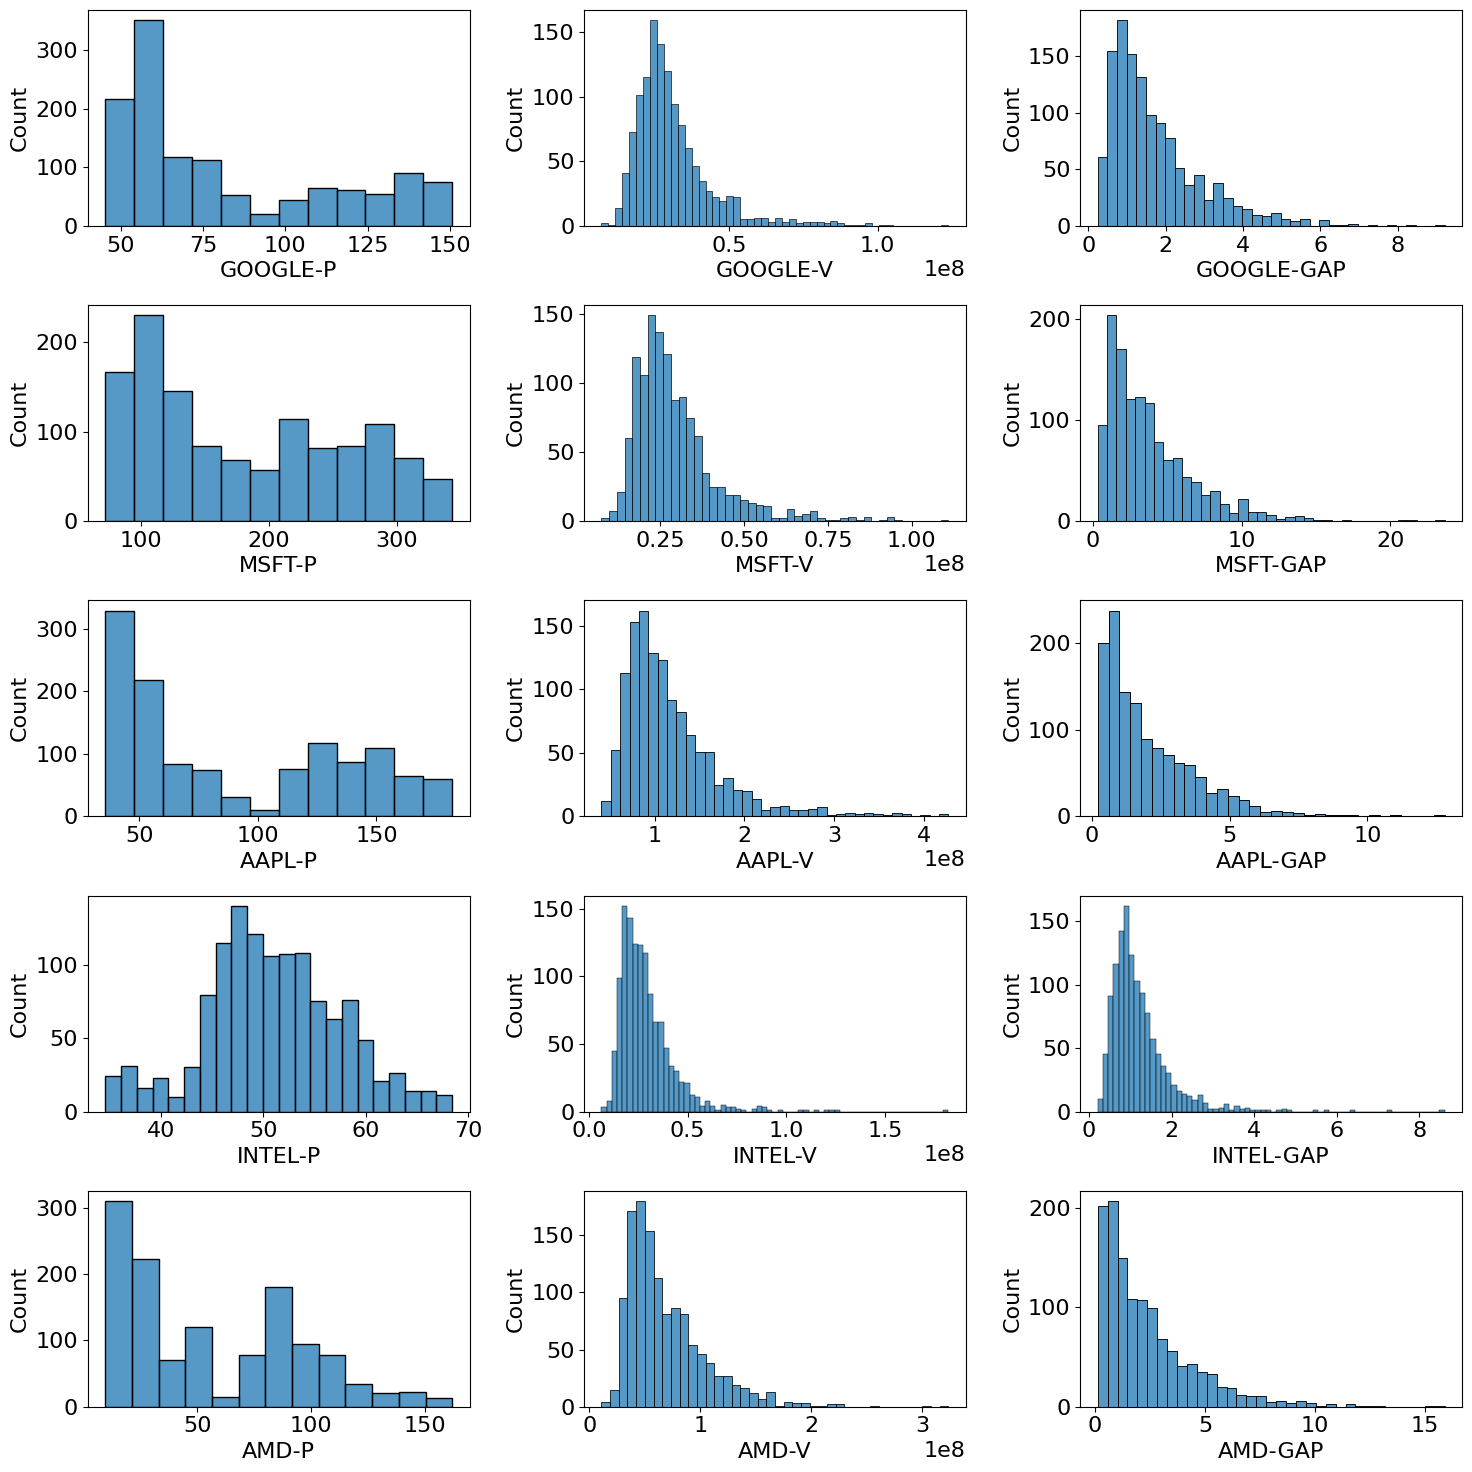

In [5]:
fig, axes = plt.subplots(5,3,figsize=(15,15))
for i, c in enumerate(data.columns[:15]):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
plt.tight_layout()

Podem mostrar en un *heatmap* la relació que té cada variable amb la resta.
Veiem que la majoria de variables estan fortament relacionades amb alguna altre, normalment, amb les del mateix tipus pero de altres marques.

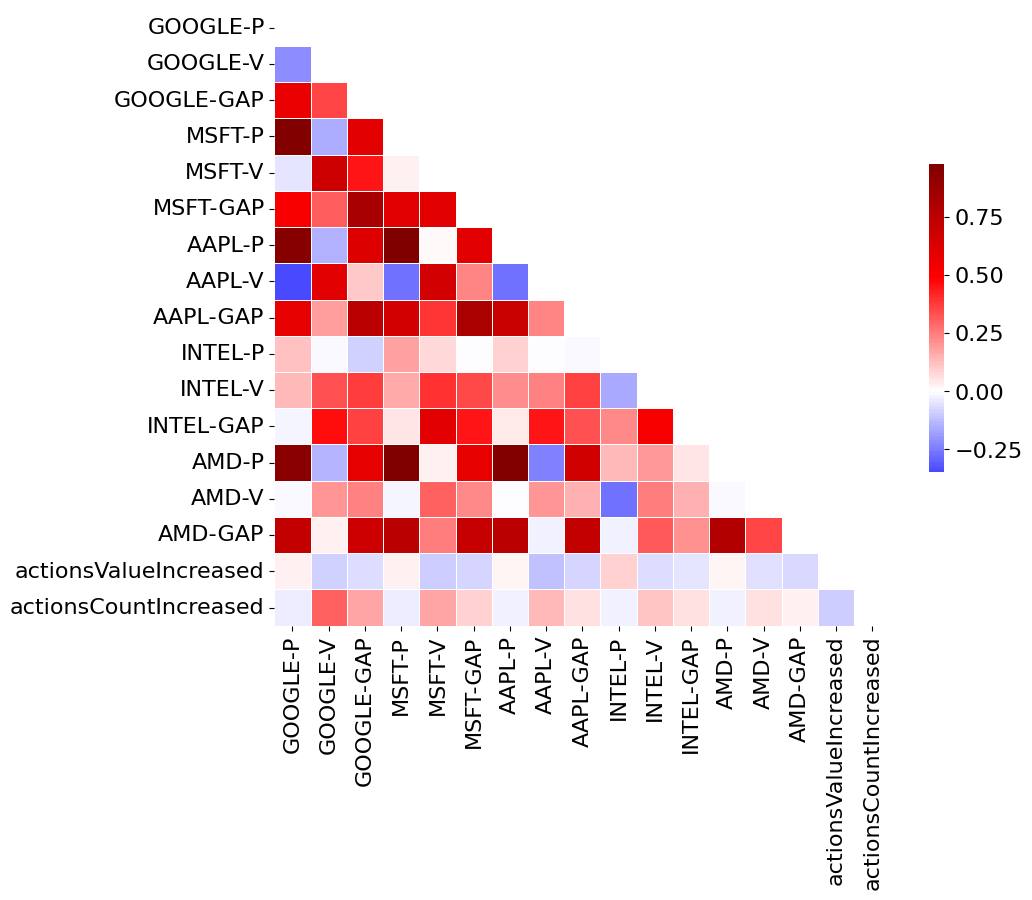

In [6]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Tractament de les dades

dividirem el nostre *dataset* en 1000 files, que ens serviran com a conjunt d'entrenament, i la resta que seran el nostre conjunt de test

In [7]:
s = 1000
data_train = data.iloc[:s]
data_test = data.iloc[s:]

Normalitzem els valors i els transformem en un array de numpy per poder aplicar les seguents trasnformacions de forma més comode

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train_n = scaler.fit_transform(data_train.to_numpy())
data_test_n = scaler.transform(data_test.to_numpy())

Dividim les dades en finestres de 3 dies, de forma que cada fila de dades, tingui informacio de 3 dies de les dades originals, mes les columnes que hem afegit. A aquesta fila de dades, li correspon una fila "objectiu" que correspon a la variable objctiu del 4rt dia

In [9]:
from numpy.lib.stride_tricks import sliding_window_view
w = 3

windows_train = sliding_window_view(data_train_n, w+1, axis=0).copy()
windows_test = sliding_window_view(data_test_n, w+1, axis=0).copy()


X_train_w, y_train_w1, y_train_w2 = windows_train.squeeze()[:,:, :-1], [*map(lambda x : x[w], windows_train.squeeze()[:,-2])], [*map(lambda x : x[w], windows_train.squeeze()[:,-1])]
X_test_w, y_test_w1, y_test_w2 = windows_test.squeeze()[:,:,:-1], [*map(lambda x: x[w], windows_test.squeeze()[:,-2])] , [*map(lambda x : x[w], windows_test.squeeze()[:,-1])]

X_train_w = X_train_w.reshape(w-s, w*data.columns.size)
X_test_w = X_test_w.reshape(len(data)-w-s, w*data.columns.size)

## Entrenament de models

### Experiment 1: Perdir si el valor de la acció pujara o baixarà

Començarem entrenant un model basat en una regressió logistica. Per aquest model, explorarem els parametres *penalty* i *C* per obtenir el millor resultat

In [10]:
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
import logging
logging.captureWarnings(False)
warnings.filterwarnings('ignore')


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_w,y_train_w1)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w1,cv=10)))

param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_bs.fit(X_train_w, y_train_w1)

LogisticRegression(max_iter=1000)

0.5085858585858587


BayesSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
              search_spaces={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                             'penalty': ['l2']})

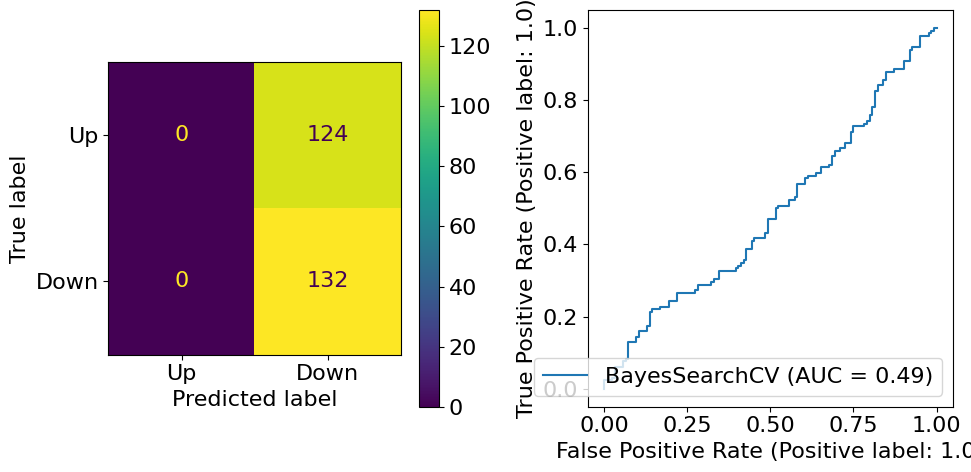

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

Veiem que el resultat es molt dolent. Si ens fixem en la matri de confusio o en la columna *support*, veiem que el model classifica tots els exemples com a "UP", i com es d'esperar, s'equivoca aproximadament un 50% dels cops.

In [12]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w1, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.00      0.00      0.00         0
        Down       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



Podem provar d'entrenar un model de xarxa neuronal per veure si el resultat obtingut es millor que l'anterior

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w1,cv=10)))

mlp_bs = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=5, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w1)

0.5417272727272727


BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=5, test_size=None),
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
                             'n_iter_no_change': [30, 40, 50]})

In [14]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.95, 'n_iter_no_change': 30}",-0.452,1
2,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.452,1
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 40}",-0.452,1
7,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.452,1
10,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.455,5


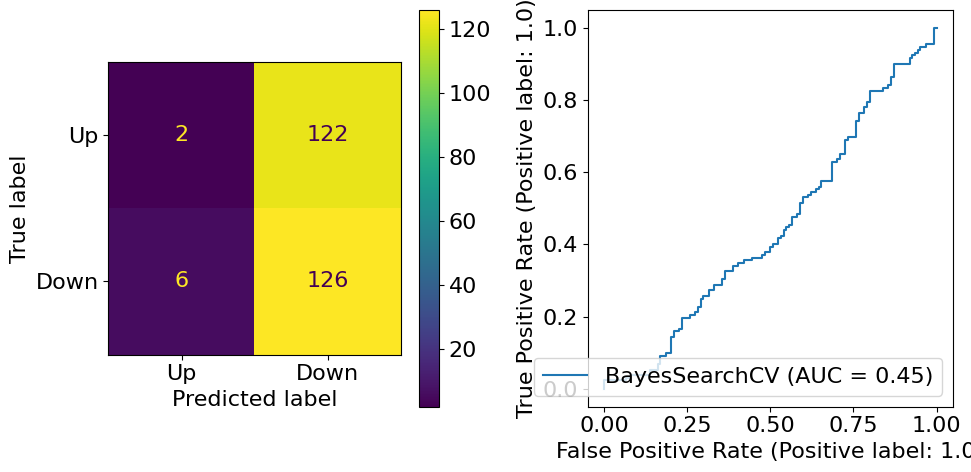

In [15]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

Tot hi que el resultat en el conjunt d'entrenament es lleuregament millor, al validar-ho amb el conjunt de test veiem que te exactament el mateix problema que l'anterior. Esta posant garebé tots els exemples a la mateixa classe, encertant així aproximadament un 50%.

In [16]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w1, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.02      0.25      0.03         8
        Down       0.95      0.51      0.66       248

    accuracy                           0.50       256
   macro avg       0.49      0.38      0.35       256
weighted avg       0.93      0.50      0.64       256



### Experiment 2: Perdir si el nombre d'accions creixerà

Provarem ara, de predir la segona variable creada. Aquesta variable ens diu si el nombre d'accions de google ha pujat o a disminuït respecte el dia anterior. Igual que abans, comencem amb el model de regresió logistica.

In [17]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_w,y_train_w2)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w2,cv=10)))

param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_bs.fit(X_train_w, y_train_w2)

LogisticRegression(max_iter=10000)

0.650939393939394


BayesSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
              search_spaces={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                             'penalty': ['l2']})

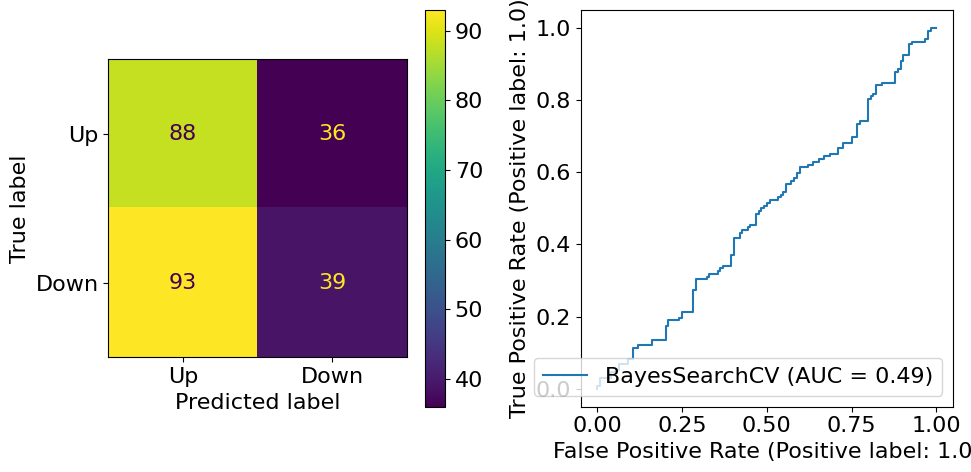

In [18]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

Veiem que els resultats han millorat lleuregament. Sembla també, que el model es sobre ajusta un mica, ja que la puntiació en el conjunt d'entrenament es una mica superior a la de test

In [19]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w2, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.79      0.60      0.68       181
        Down       0.39      0.61      0.47        75

    accuracy                           0.60       256
   macro avg       0.59      0.61      0.58       256
weighted avg       0.67      0.60      0.62       256



Provarem ara amb el model de Xarxes neuronals

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w2,cv=10)))

mlp_bs = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=5, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w2)

0.5818989898989899


BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=5, test_size=None),
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
                             'n_iter_no_change': [30, 40, 50]})

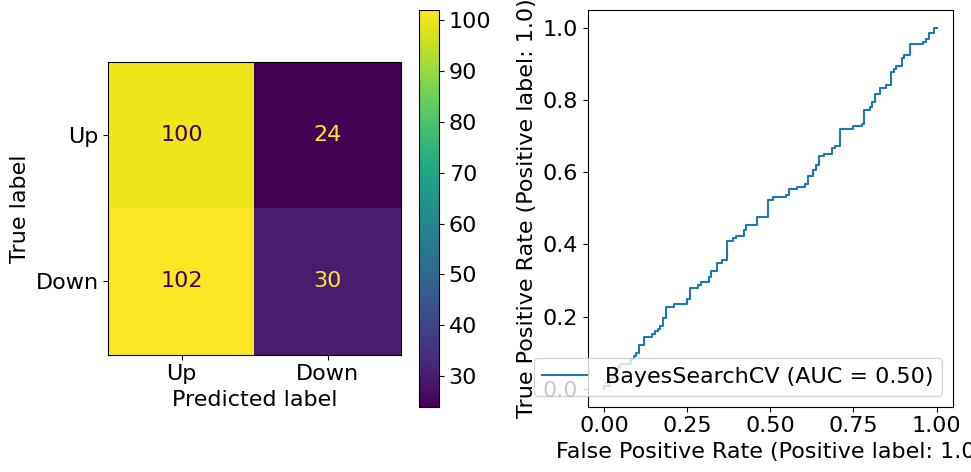

In [21]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

El resultat segueix sent millor que en el primer experiment. No obstant això, seguiex segueixent sent resultats molt dolents.

In [22]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w2, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.84      0.57      0.68       202
        Down       0.27      0.59      0.37        54

    accuracy                           0.57       256
   macro avg       0.55      0.58      0.52       256
weighted avg       0.72      0.57      0.61       256



## Conclusions

Com hem vist en els experiments, cap dels models provats ha resultat massa encertat a l'hora de predir ja sigui si el preu de la acció serà mes alt o si el nombre de les accions serà mes alt que el dia anteriror. Te sentit, ja que el mon bursatil es un mon molt complex i si amb tanta poca informació poguesim entrenar un model que, consistentment ens predigués si les accions d'una empresa cotitzaran millor o pitjor que el dia anterior, invertir a la borsa seria molt senzill.